In [ ]:
"""
This notebook is used to run the RHFE calculations.
Version: 1.0
Author: CraigVW
"""

import pandas as pd
import openfe
from openfe import SmallMoleculeComponent
from rdkit import Chem
from rdkit.Chem import AllChem
from openfe.protocols.openmm_utils.omm_settings import OpenFFPartialChargeSettings
from openfe.protocols.openmm_utils.charge_generation import bulk_assign_partial_charges
from openfe.utils.atommapping_network_plotting import plot_atommapping_network
from openfe import SolventComponent
from openfe.protocols.openmm_rfe import RelativeHybridTopologyProtocol

from openff.units import unit
from pathlib import Path

class AlchemistRHFE:
    def __init__(self, csv_path):
        self.csv_path = csv_path
        
        # Get the set name
        self.set_name = csv_path.split('/')[-1].split('.')[0]
        self.network_setup_dir = Path(f"./network_setup/{self.set_name}")
        self.transformation_dir = self.network_setup_dir / f"transformations_{self.set_name}"
        
        # Create the directory

        if not self.network_setup_dir.exists:
            self.network_setup_dir.mkdir(exist_ok=True)
        if not self.transformation_dir.exists:
            self.transformation_dir.mkdir(exist_ok=True)
        
    def run_rhfe(self):

    
        # Read in the ligand data
        ligand_df = pd.read_csv(self.csv_path, sep=',', header=0)
        
        # Convert the SMILES strings to RDKit molecules and put them into a SmallMoleculeComponent list
        ligands = []
        for index, row in ligand_df.iterrows():
            ligand_id = row['Ligand_ID']
            smiles_string = row['SMILES']
            mol = Chem.MolFromSmiles(smiles_string)
            mol_h = Chem.AddHs(mol)
            AllChem.EmbedMolecule(mol_h, randomSeed=0)
            small_mol = SmallMoleculeComponent.from_rdkit(mol_h, ligand_id)
            ligands.append(small_mol)

        # Assign partial charges
        charge_settings = OpenFFPartialChargeSettings(partial_charge_method="am1bcc", off_toolkit_backend="ambertools")
        charged_ligands = bulk_assign_partial_charges(
            molecules=ligands,
            overwrite=False,
            method=charge_settings.partial_charge_method,
            toolkit_backend=charge_settings.off_toolkit_backend,
            generate_n_conformers=charge_settings.number_of_conformers,
            nagl_model=charge_settings.nagl_model,
            processors=1
            )
        
        # Create the ligand network
        mapper = openfe.LomapAtomMapper(max3d=1.0, element_change=False)
        scorer = openfe.lomap_scorers.default_lomap_score
        network_planner = openfe.ligand_network_planning.generate_minimal_spanning_network

        ligand_network = network_planner(
            ligands=charged_ligands,
            mappers=[mapper],
            scorer=scorer
            )
        
        # Plot the ligand network
        plot_atommapping_network(ligand_network)

        # Save the ligand network        
        ligand_network_file = self.network_setup_dir / f"ligand_network_{self.set_name}.graphml"
        try:
            with open(ligand_network_file, mode='w') as f:
                f.write(ligand_network.to_graphml())
        except Exception as e:
            print(f"写入ligand_network文件时出错: {e}")
        
        # Define the SolventComponent
        solvent = SolventComponent(positive_ion='Na', negative_ion='Cl',
                                neutralize=True, ion_concentration=0.15*unit.molar)
        
        # Create a protocol for the solvent legs using default settings
        solvent_protocol = RelativeHybridTopologyProtocol(RelativeHybridTopologyProtocol.default_settings())

        # Create the transformations
        transformations = []
        for mapping in ligand_network.edges:
            
            # use the solvent and protein created above
            sysA_dict = {'ligand': mapping.componentA,
                            'solvent': solvent}
            sysB_dict = {'ligand': mapping.componentB,
                            'solvent': solvent}


            # If this is a solvent transformation we just use the solvent protocol
            protocol = solvent_protocol

            # we don't have to name objects, but it can make things (like filenames) more convenient
            sysA = openfe.ChemicalSystem(sysA_dict, name=f"{mapping.componentA.name}_ligand")
            sysB = openfe.ChemicalSystem(sysB_dict, name=f"{mapping.componentB.name}_ligand")

            prefix = "rbfe_"  # prefix is only to exactly reproduce CLI

            transformation = openfe.Transformation(
                stateA=sysA,
                stateB=sysB,
                mapping=mapping,
                protocol=protocol,  # use protocol created above
                name=f"{prefix}{sysA.name}_{sysB.name}"
            )
            transformations.append(transformation)

        # Get the alchemical network
        network = openfe.AlchemicalNetwork(transformations)

        # Save the alchemical network
        network.to_json(self.network_setup_dir / f"network_{self.set_name}.json")

        # Write out each transformation
        for transformation in network.edges:
            transformation.to_json(self.transformation_dir / f"{transformation.name}.json")

        return 0

Generating charges: 100%|███████████████████████| 18/18 [19:13<00:00, 64.10s/it]


Mapping:   1%|          | 1/153 [00:03<08:40,  3.42s/it]

NameError: name 'set_name' is not defined

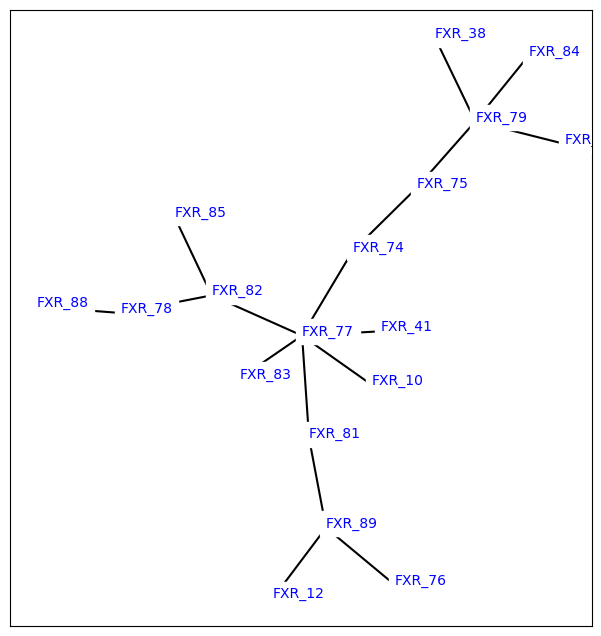

In [2]:
set_1_csv_path = "./dataset/FXR/FEP_set_1.csv"
set_2_csv_path = "./dataset/FXR/FEP_set_2.csv"

rbfe = AlchemistRHFE(set_2_csv_path)
rbfe.run_rhfe()

In [ ]:
!ls ./network_setup/FXR_set_1/transformations_set_2